In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class LatLong2Grid:
    def __init__(self):
        self.min_lat = 22.502
        self.max_lat = 22.688
        self.min_long = 113.813
        self.max_long = 114.293
        self.max_grid_long = 480
        self.max_grid_lat = 187
    
    def process_df(self, df):
        df['time'] = pd.to_datetime(df["time"])
        df.sort_values(by="time")
        df['longitude'] = df['longitude'].round(3)
        df['latitude'] = df['latitude'].round(3)
        s1 = ((df['longitude']<=self.max_long)&(df['longitude']>=self.min_long))
        s2 = ((df['latitude']<=self.max_lat)&(df['latitude']>=self.min_lat))
        slice_ = s1 & s2 
        df = df[slice_]
        df['long'] = df['longitude'].apply(lambda x: int(
            self.max_grid_long*((x-self.min_long)/(self.max_long - self.min_long)))
                                          )
        df['lat'] = df['latitude'].apply(lambda x: int(
            self.max_grid_lat - self.max_grid_lat*((x-self.min_lat)/(self.max_lat - self.min_lat)))
                                        )
        return df
    
    def get_indicies(self, df):
        df = df.reset_index()
        df['flag'] = df['status'].diff(periods=1)
        start = df.iloc[0].status
        df['flag'].iloc[0] = 0
        indicies = df[df['flag'].isin([-1, 1])].index.to_list()
        indicies.insert(0, 0)
        indicies.append(df.shape[0])
        return indicies, start
    
    def draw_trajectory(self, df):
        color = (0, 0, 0)  
        thickness = 2
        image = np.ones((self.max_grid_lat, self.max_grid_long), np.uint8)
        points = list(df[['long', 'lat']].to_numpy())
#         for j in range(temp_df.shape[0]):
#             x1, y1 = temp_df.iloc[j].long, self.max_grid_lat - temp_df.iloc[j].lat
#             points.append([x1, y1])
        points = np.asarray(points, np.int32)
#         np.put(image, points, 255)
        image = cv2.polylines(image, [points], False, color, thickness)
        return image
    
    def get_feature(self, df):
        indices, start = self.get_indicies(df)
        all_features = []
        for j in tqdm(range(0, len(indices)-2, 2)):
            if start == 1:
                first_image = self.draw_trajectory(df[indices[j]:indices[j+1]])
                second_image = self.draw_trajectory(df[indices[j+1]:indices[j+2]])
            else:
                first_image = self.draw_trajectory(df[indices[j+1]:indices[j+2]])
                second_image = self.draw_trajectory(df[indices[j]:indices[j+1]])
            all_features.append(np.stack([first_image, second_image], axis=0))
        return all_features

In [3]:
data_dir = "../data/data_5drivers/"
all_csv_names = os.listdir(data_dir)
print(len(all_csv_names))

179


In [4]:
lat_long_to_grid = LatLong2Grid()

In [5]:
id_ = 50
df = pd.read_csv(os.path.join(data_dir, all_csv_names[id_]))
df = lat_long_to_grid.process_df(df)
df.head()

/tmp/ipykernel_15848/2068128663.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long'] = df['longitude'].apply(lambda x: int(
/tmp/ipykernel_15848/2068128663.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'] = df['latitude'].apply(lambda x: int(


,plate,longitude,latitude,time,status,long,lat
0,1,114.118,22.537,2016-09-03 00:08:54,1,304,151
2,2,113.949,22.579,2016-09-03 00:08:55,1,135,109
3,2,113.949,22.579,2016-09-03 00:08:56,1,135,109
4,2,113.948,22.578,2016-09-03 00:09:03,1,134,110
5,3,114.118,22.577,2016-09-03 00:09:05,0,304,111


In [6]:
plate = 0
temp_df = df[df['plate']==plate]
features = lat_long_to_grid.get_feature(temp_df)

/tmp/ipykernel_15848/2068128663.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flag'].iloc[0] = 0
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 633.00it/s]


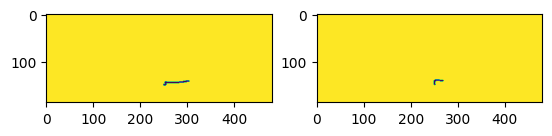

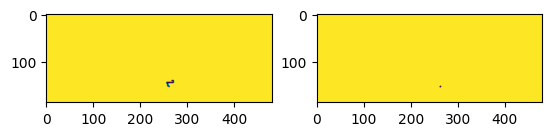

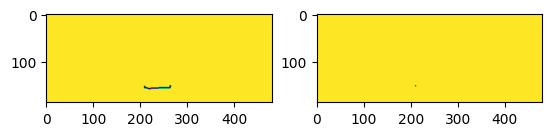

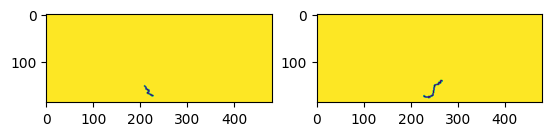

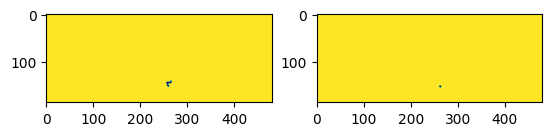

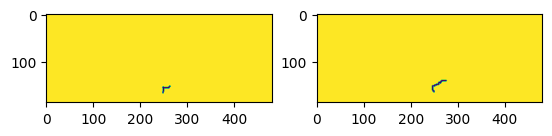

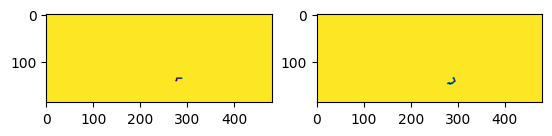

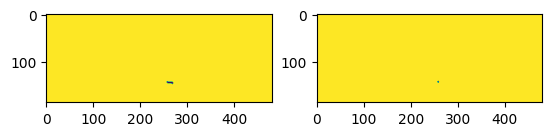

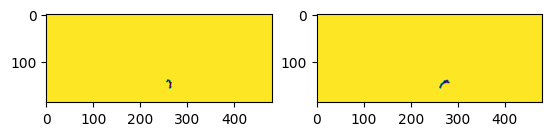

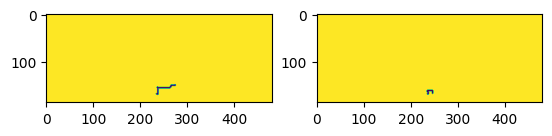

In [8]:
for idx in range(10):
    fig, axes = plt.subplots(1, 2)
    axes = axes.ravel()
    for i in range(features[idx].shape[0]):
        axes[i].imshow(features[idx][i])
plt.show()